In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import random
import cv2
import matplotlib.pyplot as plt
import math

import copy
from scipy import ndimage

In [2]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# taken from class

style_im = read_image('/home/chris/catchup/DL/HW4/starry.jpg')
content_im = read_image('/home/chris/catchup/DL/HW4/us.jpg')

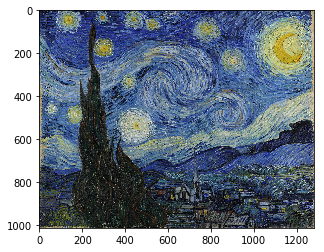

In [3]:
plt.imshow(style_im)

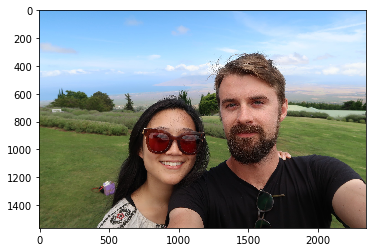

In [4]:
plt.imshow(content_im)

In [5]:
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# taken from class and fast.ai

style_im = center_crop(style_im)
style_im = cv2.resize(style_im, (400, 400))
content_im = center_crop(content_im)
content_im = cv2.resize(content_im, (400, 400))

style_im.shape, content_im.shape

((400, 400, 3), (400, 400, 3))

In [6]:
def transform_images(im):
    """ Transform images to be ready for pre-trained network as 
        we need n_batch, n_channels, h,w format
    """
    im = np.rollaxis(im, 2)
    im = im[None]
    return torch.tensor(im, dtype=torch.float32).cuda()

In [7]:
style_img = transform_images(style_im/255)
content_img = transform_images(content_im/255)

In [8]:
style_img.shape, content_img.shape

(torch.Size([1, 3, 400, 400]), torch.Size([1, 3, 400, 400]))

### Style Transfer

In [9]:
def get_im_opt():
    opt_img = np.random.uniform(0, 1, size=content_im.shape).astype(np.float32)
    opt_img = ndimage.filters.median_filter(opt_img, [8,8,1])
    im_opt = transform_images(opt_img)
    im_opt.requires_grad=True
    optimizer = optim.LBFGS([im_opt], lr=0.01)
    return im_opt, optimizer

In [10]:
class inception_net(nn.Module):
    def __init__(self):
        """Select conv1_1 ~ conv5_1 activation maps."""
        super(inception_net, self).__init__()
        inc = models.inception_v3(pretrained=True).cuda().eval()
        inc.Conv2d_1a_3x3.conv.stride = (1,1)
        inc_model = nn.Sequential(*list(inc.children())[:11])
        for p in list(inc_model.parameters()):
            p.requires_grad = False
        self.select = ['5', '7', '10']
        self.inc_model = inc_model
        
    def forward(self, x):
        """Extract multiple convolutional feature maps."""
        features = []
        for name, layer in self.inc_model._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

In [11]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # unrolling feature maps

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [12]:
inc_net = inception_net()

In [13]:
im_style_f = inc_net(style_img)

In [14]:
[o.shape for o in im_style_f]

[torch.Size([1, 256, 394, 394]),
 torch.Size([1, 288, 394, 394]),
 torch.Size([1, 768, 196, 196])]

In [15]:
# gram matrix of style image
targ_g = [gram_matrix(f).detach() for f in im_style_f]
[o.shape for o in targ_g]

[torch.Size([256, 256]), torch.Size([288, 288]), torch.Size([768, 768])]

In [16]:
def train_style_transfer(optimizer, targ_g, targ_v, im_opt, iters, weights, alpha):
    """weight layers differently for style"""
    for i in range(iters):
        # constrain image to be between (0,1)
        im_opt.data.clamp_(0, 1)
        optimizer.zero_grad()
        # run the model
        out = inc_net(im_opt)
        input_g = [gram_matrix(f) for f in out]
        losses = [F.mse_loss(o, t)*w for o,t,w in zip(input_g, targ_g, weights)]
        loss = sum(losses)*1000*alpha
        if i%10 == 0: print('style loss:', loss.item())
        content_loss = F.mse_loss(out[0], targ_v.detach())
        if i%10 == 0: print('content_loss: ', content_loss.item())
        loss += content_loss
        loss.backward()
        if i%10 == 0: print('Epoch: ', i,'|', loss.item())
        optimizer.step()
    im_opt.data.clamp_(0, 1)
    return im_opt

In [17]:
im_content = transform_images(content_im/255)
im_style = transform_images(style_im/255)
im_content.shape, im_style.shape

(torch.Size([1, 3, 400, 400]), torch.Size([1, 3, 400, 400]))

In [18]:
inc_net = inception_net()
im_style_f = inc_net(im_style)
targ_g = [gram_matrix(f).detach() for f in im_style_f]

In [19]:
im_content_f = inc_net(im_content)
targ_v = im_content_f[0].detach()
targ_v.shape

torch.Size([1, 256, 394, 394])

In [20]:
for f in im_content_f:
    print(f.shape)

torch.Size([1, 256, 394, 394])
torch.Size([1, 288, 394, 394])
torch.Size([1, 768, 196, 196])


In [21]:
im_opt, optimizer = get_im_opt()

In [22]:
optimizer = optim.Adam([im_opt], lr=.1)
im_opt = train_style_transfer(optimizer, targ_g, targ_v, im_opt, 200,
                              weights=[1,1,1], alpha=1000)

style loss: 1.054746389389038
content_loss:  0.14758004248142242
Epoch:  0 | 1.2023264169692993
style loss: 0.32168683409690857
content_loss:  0.3139084577560425
Epoch:  10 | 0.6355953216552734
style loss: 0.08070187270641327
content_loss:  0.24216653406620026
Epoch:  20 | 0.3228684067726135
style loss: 0.029620053246617317
content_loss:  0.18564988672733307
Epoch:  30 | 0.21526993811130524
style loss: 0.016221852973103523
content_loss:  0.14677928388118744
Epoch:  40 | 0.1630011349916458
style loss: 0.012026633135974407
content_loss:  0.12349540740251541
Epoch:  50 | 0.1355220377445221
style loss: 0.011059273965656757
content_loss:  0.11030633002519608
Epoch:  60 | 0.12136560678482056
style loss: 0.010859760455787182
content_loss:  0.10258453339338303
Epoch:  70 | 0.11344429105520248
style loss: 0.010673129931092262
content_loss:  0.09785694628953934
Epoch:  80 | 0.10853007435798645
style loss: 0.010461019352078438
content_loss:  0.0947871282696724
Epoch:  90 | 0.10524814575910568
sty

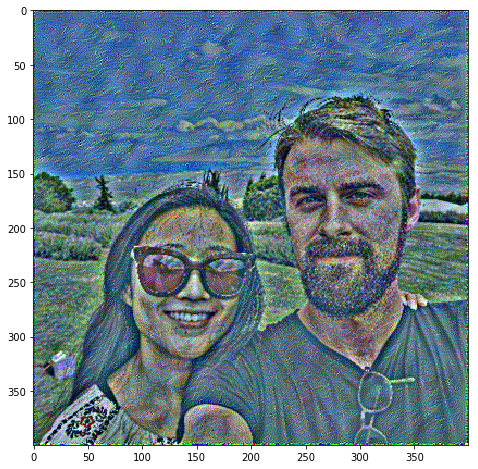

In [24]:
x = im_opt.cpu().detach().numpy()
x = np.rollaxis(x[0],0,3)
plt.figure(figsize=(8,8))
plt.imshow(x)
plt.savefig('us_transformed.png')

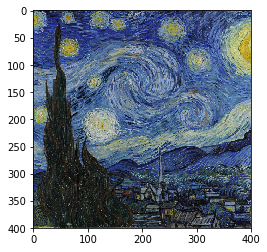

In [25]:
plt.imshow(style_im)

# Conslusion

It worked somewhat. Was nice to play around with style transfer using a completely new architecture.